# Dry Bean

This dataset is from [UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/dry+bean+dataset).


In [1]:
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True

## Setup

First, we load all the packages required for running the five algorithms and analyzing their performance.


In [2]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn import base
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from scipy.io import arff

from typing import Any
from typing import Union

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing



This dataset from UCI Data Repository has already been cleaned up and has no unknown values.

- Use the `preprocessing.OrdinalEncoder` module to encode the **Class** column
- Scale the features
- Split the data into **Training** and **Test** sets


In [3]:
data = pd.DataFrame(arff.loadarff('data/Dry_Bean_Dataset.arff')[0])

features = preprocessing.scale(data.drop(['Class'], axis=1))
target = data["Class"]

print(f"Number of samples: {target.size}")
print(
    f"Percentage of SEKER: {target.value_counts(normalize=True)[b'SEKER'] * 100:.3f}%")
print(
    f"Percentage of BARBUNYA: {target.value_counts(normalize=True)[b'BARBUNYA'] * 100:.3f}%")
print(
    f"Percentage of BOMBAY: {target.value_counts(normalize=True)[b'BOMBAY'] * 100:.3f}%")
print(
    f"Percentage of CALI: {target.value_counts(normalize=True)[b'CALI'] * 100:.3f}%")
print(
    f"Percentage of HOROZ: {target.value_counts(normalize=True)[b'HOROZ'] * 100:.3f}%")
print(
    f"Percentage of SIRA: {target.value_counts(normalize=True)[b'SIRA'] * 100:.3f}%")
print(
    f"Percentage of DERMASON: {target.value_counts(normalize=True)[b'DERMASON'] * 100:.3f}%")

data["Class"] = preprocessing.OrdinalEncoder().fit_transform(data[["Class"]])
target = data["Class"]

print("Splitting into train/test sets...", end="")
FEATURES_TRAIN, FEATURES_TEST, TARGET_TRAIN, TARGET_TEST = train_test_split(
    features, target, test_size=0.3, random_state=42)
print("Done")

print("Setting up global variables...", end="")
classifier_accuracy = np.zeros(6)
train_time = np.zeros(6)
infer_time = np.zeros(6)
print("Done")


Number of samples: 13611
Percentage of SEKER: 14.892%
Percentage of BARBUNYA: 9.713%
Percentage of BOMBAY: 3.835%
Percentage of CALI: 11.976%
Percentage of HOROZ: 14.165%
Percentage of SIRA: 19.367%
Percentage of DERMASON: 26.052%
Splitting into train/test sets...Done
Setting up global variables...Done


## Helper Functions & Global Variables


In [4]:
TARGET_CLASSES = ['SEKER', 'BARBUNYA', 'BOMBAY',
                  'CALI', 'HOROZ', 'SIRA', 'DERMASON']


def plot_confusionmatrix(predicted, expected, dom) -> None:
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(predicted, expected)
    sns.heatmap(cf, annot=True, yticklabels=TARGET_CLASSES,
                xticklabels=TARGET_CLASSES, cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()


In [5]:
ClassifierMixin = Union[DecisionTreeClassifier, MLPClassifier,
                        AdaBoostClassifier, SVC, KNeighborsClassifier]


def default_fit_test(classifier: ClassifierMixin) -> None:
    classifier.fit(FEATURES_TRAIN, TARGET_TRAIN)

    train_pred = classifier.predict(FEATURES_TRAIN)
    test_pred = classifier.predict(FEATURES_TEST)

    print(f'Train score {accuracy_score(train_pred, TARGET_TRAIN)}')
    print(f'Test score {accuracy_score(test_pred, TARGET_TEST)}')
    plot_confusionmatrix(train_pred, TARGET_TRAIN, dom='Train')
    plot_confusionmatrix(test_pred, TARGET_TEST, dom='Test')


In [6]:
def grid_search_and_best_fit(classifier: ClassifierMixin, param_grid: dict[str, Any], index: int, name: str) -> GridSearchCV:
    classifier_best = GridSearchCV(
        classifier, param_grid=param_grid, cv=4)

    start_time = time.time()
    classifier_best.fit(FEATURES_TRAIN, TARGET_TRAIN)
    end_time = time.time()
    train_time[index] = end_time - start_time
    print(f"Best params for {name}: {classifier_best.best_params_}")

    return classifier_best


In [7]:
def best_fit_test(classifier_best: GridSearchCV, index: int, name: str) -> None:
    best_train_pred = classifier_best.predict(FEATURES_TRAIN)
    print(
        f"Accuracy for best {name} on train sets: {accuracy_score(TARGET_TRAIN, best_train_pred)}")
    start_time = time.time()
    best_test_pred = classifier_best.predict(FEATURES_TEST)
    classifier_accuracy[index] = accuracy_score(TARGET_TEST, best_test_pred)
    end_time = time.time()
    infer_time[index] = end_time - start_time
    print(
        f"Accuracy for best {name} on test sets: {classifier_accuracy[index]}")

    plot_confusionmatrix(best_train_pred, TARGET_TRAIN,
                         dom="Train Set with Best Params")
    plot_confusionmatrix(best_test_pred, TARGET_TEST,
                         dom="Test Set with Best Params")


In [8]:
def plot_learning_curve(classifier_learning: ClassifierMixin, name: str):
    _, train_scores, val_scores = learning_curve(
        classifier_learning, FEATURES_TRAIN, TARGET_TRAIN, train_sizes=np.linspace(0.1, 1.0, 10), cv=4)

    plt.figure()
    plt.plot(np.linspace(0.1, 1.0, 10)*100,
             np.mean(train_scores, axis=1), label='Train Score')
    plt.plot(np.linspace(0.1, 1.0, 10)*100,
             np.mean(val_scores, axis=1), label='CV Score')
    plt.legend()
    plt.title(f"Learning Curve ({name})")
    plt.xlabel("Percentage of Training Examples")
    plt.ylabel("Score")
    plt.xticks(np.linspace(0.1, 1.0, 10) * 100)
    plt.grid()
    plt.savefig(
        f"images/dry_bean/dry_bean_{'_'.join(name.lower().split(' '))}_learning_curve.png")
    plt.show()


In [9]:
def plot_validation_curve(
        classifier: ClassifierMixin, param_name: str,
        param_range: np.ndarray, name: str,
        xticks: np.ndarray = None, default_xticks: bool = False,
        xaxis_log: bool = False) -> None:
    train_scores, val_scores = validation_curve(
        classifier, FEATURES_TRAIN, TARGET_TRAIN, param_name=param_name, param_range=param_range, cv=4)

    plt.figure()
    if xaxis_log:
        plt.semilogx(param_range, np.mean(train_scores, axis=1), label='Train Score')
        plt.semilogx(param_range, np.mean(val_scores, axis=1), label='CV Score')
    else:
        plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score')
        plt.plot(param_range, np.mean(val_scores, axis=1), label='CV Score')
    plt.legend()
    plt.title(f"Validation Curve ({name})")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    if default_xticks:
        pass
    elif xticks is not None:
        plt.xticks(xticks)
    else:
        plt.xticks(param_range)
    plt.grid()
    plt.savefig(
        f"images/dry_bean/dry_bean_{'_'.join(name.lower().split(' '))}_{param_name}_validation_curve.png")
    plt.show()


`scikit-learn` provides an extremely intuitive interface for training and evaluating machine learning models. I will be using `validation_curve` and `GridSearchCV` to cross-validate over a range of hyper-parameter values to find the best model.


## Decision Tree


### Pretuning


Train score 1.0
Test score 0.888099902056807
Train Confusion matrix


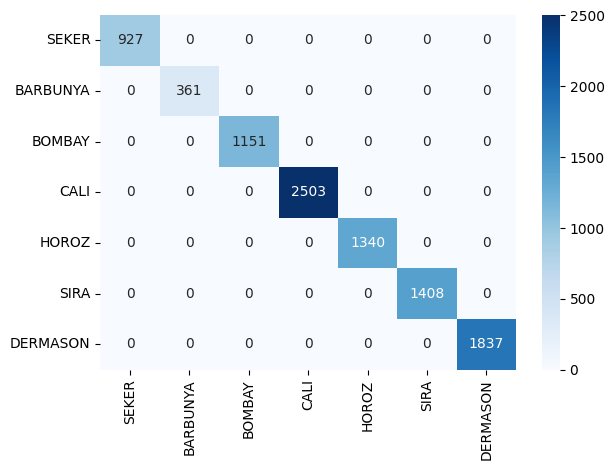

Test Confusion matrix


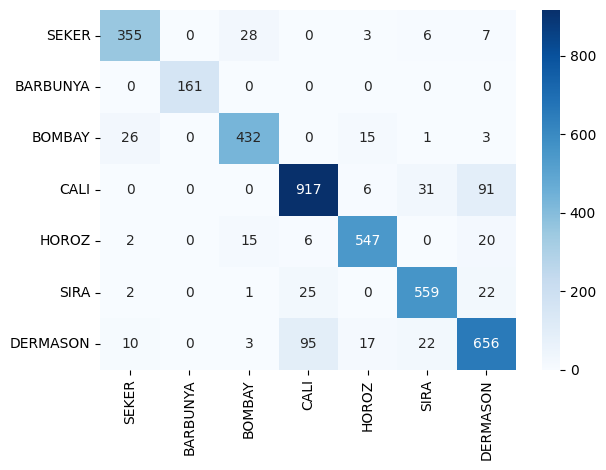

In [10]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
default_fit_test(decision_tree_classifier)


Before any study is done, a base case for the Decision Tree Classifier should be established, that is a Decision Tree Classifier with no pruning and no parameter tuning. As you can see from the confusion matrix and the accuaracy data, the decision tree can get 100% correct on the training set but merely 90% for the test set. This is a clear sign of overfitting. The decision tree is too complex and is not generalizing well.


### Tuning Maximum Depth and CCP-$\alpha$


To prevent over fitting, a maximum depth will be set as a pre-pruning method and CCP-$\alpha$ (Cost Complexoty Pruning) will be used for post-pruning. Thus, two parameters will be tuned: `max_depth` for the tree maxium depth and regularization parameter $\alpha$ for CCP. A higher value of $\alpha$ will prune more nodes out of the tree.
The range for `max_depth` is [1, 35) and the range for ccp-$\alpha$ is 10 evenly distributed datapoint between [0, 0.035).


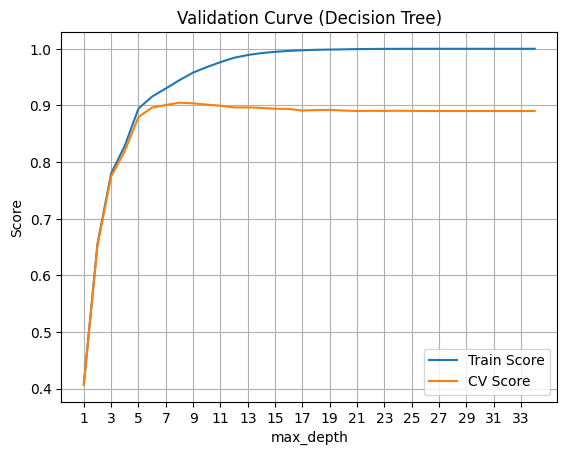

In [11]:
plot_validation_curve(
    decision_tree_classifier, 'max_depth',
    np.arange(1, 35), 'Decision Tree',
    np.arange(1, 35, 2))


From the figure above, we can see that the training score converges to 1 as the maximum depth increases. This is because the tree is getting more and more complex and can fit the training data perfectly. However, the test score does not increase as much as the training score. Instead, the test score reaches its maximum when the `max_depth` reaches a certain value and then starts to decrease when overfitting starts kicking in.

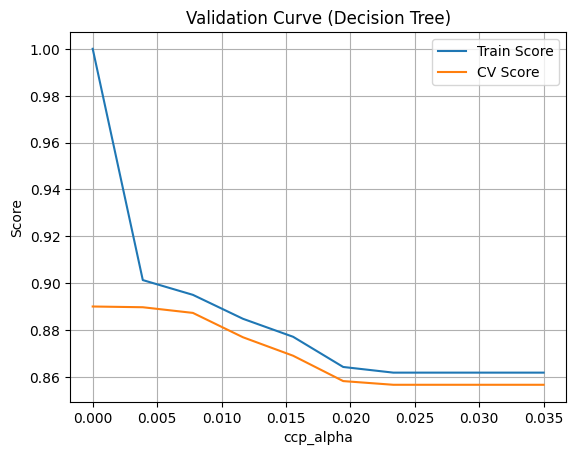

In [12]:
plot_validation_curve(
    decision_tree_classifier, 'ccp_alpha',
    np.linspace(0, 0.035, 10), 'Decision Tree',
    np.linspace(0, 0.035, 8))


From the figure above, we can see the relationship of CCP-$\alpha$ with train score and the cross validation score. They both decreases as CCP-$\alpha$ increases, which means with the current dataset, no nodes should be pruned out using the Cross Complexity Pruning algorithm.


In [13]:
param_grid = {
    'max_depth': np.arange(1, 35),
    'ccp_alpha': np.linspace(0, 0.035, 10)
}
decision_tree_classifier_best = grid_search_and_best_fit(
    decision_tree_classifier, param_grid, 0, "decision tree")


Best params for decision tree: {'ccp_alpha': 0.0, 'max_depth': 8}


After the grid search, the best parameter combination for ccp-$\alpha$ an maximum dpeth for the deicision tree classifier is 0.0 and 8 respectively.


Accuracy for best decision tree on train sets: 0.939225359504566
Accuracy for best decision tree on test sets: 0.9005876591576886
Train Set with Best Params Confusion matrix


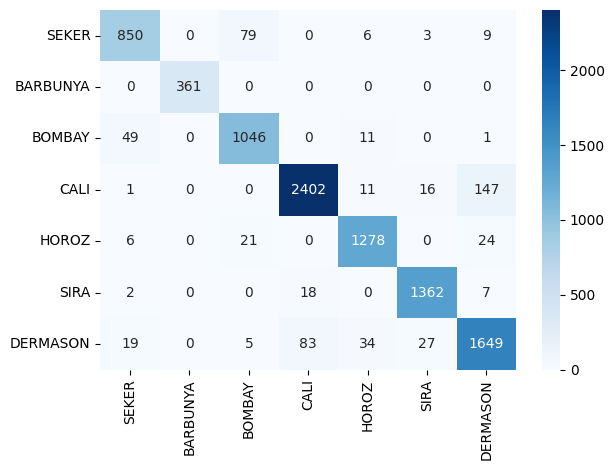

Test Set with Best Params Confusion matrix


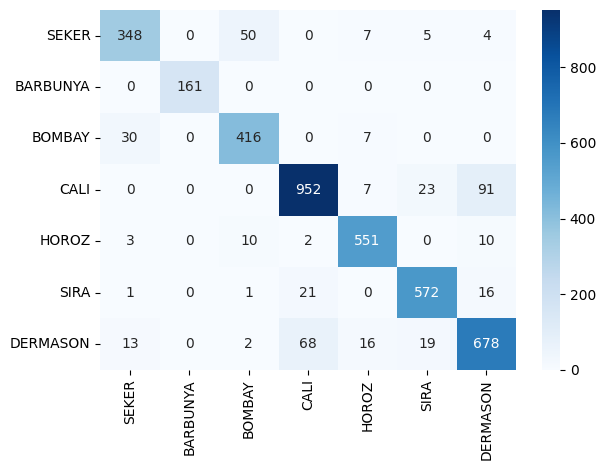

In [14]:
best_fit_test(decision_tree_classifier_best, 0, "decision tree")


The confusion matrix on training set and testing set are plotted again for comparison between the default parameter classfier and the bets parameter classifier. We can see that the accuracy score for the training set is not 100% anymore but the accuracy score for the testing set is improved by 2%. The fact that the accruacy score for both testing set and training set are not high tells me that the dataset I have chosen could be noisy.


### Deicision Tree Learning Curve


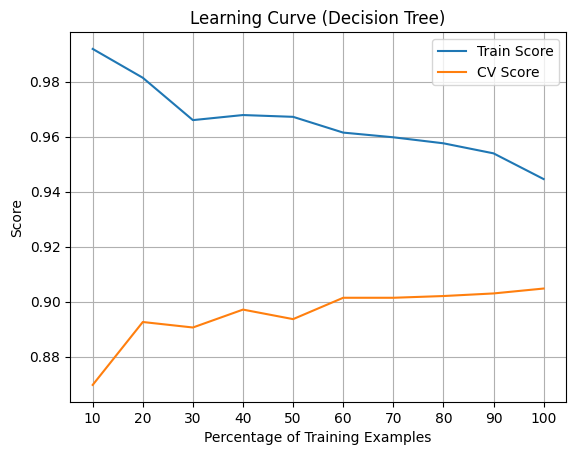

In [15]:
decision_tree_classifier_learning = DecisionTreeClassifier(
    random_state=42,
    max_depth=decision_tree_classifier_best.best_params_['max_depth'],
    ccp_alpha=decision_tree_classifier_best.best_params_['ccp_alpha']
)
plot_learning_curve(decision_tree_classifier_learning, "Decision Tree")


The gap between the train score and the CV score gets smaller and smaller when the percentage of training examples increases. However, the gap is still relatively big when it reaches 100%. This again supports the previous observation that the dataset could be noisy.


## Neural Networks


### Multi-Layer Neural Network


#### Pretuning


Train score 0.9249501417025296
Test score 0.9211557296767875
Train Confusion matrix


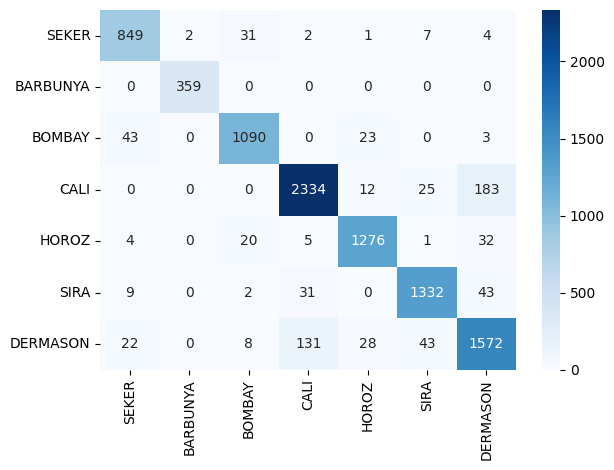

Test Confusion matrix


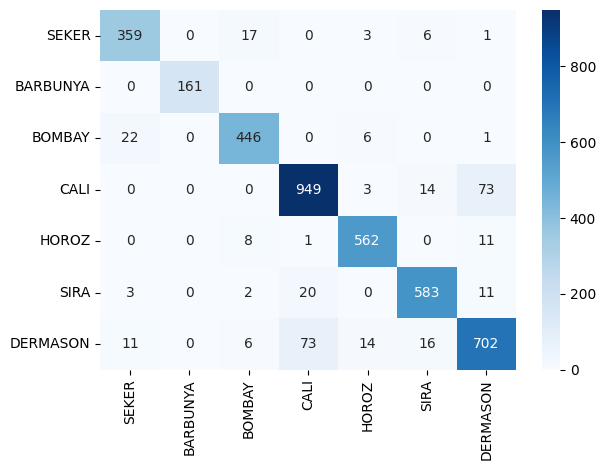

In [16]:
neural_network_classifier = MLPClassifier(
    hidden_layer_sizes=(4, 4),
    random_state=42,
    max_iter=2000
)
default_fit_test(neural_network_classifier)


Before any study is done, a base case for the Neural Network Classifier should be established. Unlike the obvious overfitting issue decision tree classfier has been showing from the get go, the nerual network classifier seems to be balancing between the testing set and the training set well, where both reached 92% of accuracy. The neural network architecture is not overly complicated with two hidden layers, with each layer containing 4 nodes each.


#### Tuning Regularization $\alpha$ and Initial Learning Rate


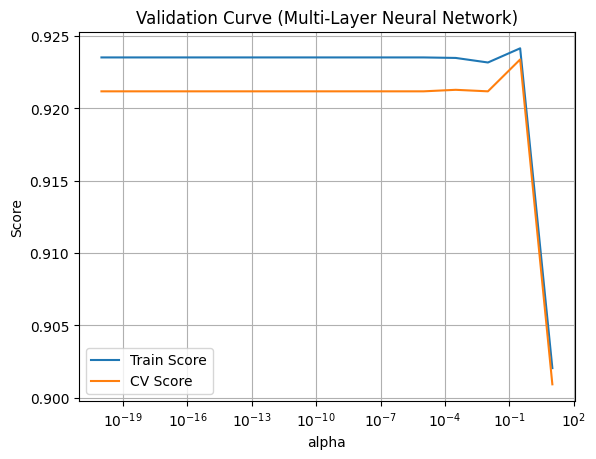

In [17]:
plot_validation_curve(
    neural_network_classifier, 'alpha',
    np.logspace(-20, 1, 15), "Multi-Layer Neural Network",
    default_xticks=True, xaxis_log=True)


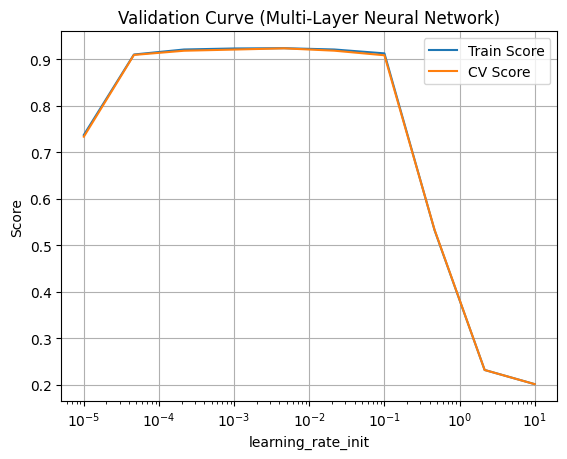

In [18]:
plot_validation_curve(
    neural_network_classifier, 'learning_rate_init',
    np.logspace(-5, 1, 10), "Multi-Layer Neural Network",
    default_xticks=True, xaxis_log=True)


In [19]:
param_grid = {
    'alpha': np.logspace(-20, 1, 15),
    'learning_rate_init': np.logspace(-5, 1, 10)
}
neural_network_classifier_best = grid_search_and_best_fit(
    neural_network_classifier, param_grid, 1, "multi-layer neural network")


Best params for multi-layer neural network: {'alpha': 1e-20, 'learning_rate_init': 0.004641588833612777}


From the grid search, the best parameters for this particular neural network structure are $1\cdot 10^{-20}$ for $\alpha$ and 0.00464 for the initial leraning rate.

Accuracy for best multi-layer neural network on train sets: 0.9236905636611735
Accuracy for best multi-layer neural network on test sets: 0.9236043095004897
Train Set with Best Params Confusion matrix


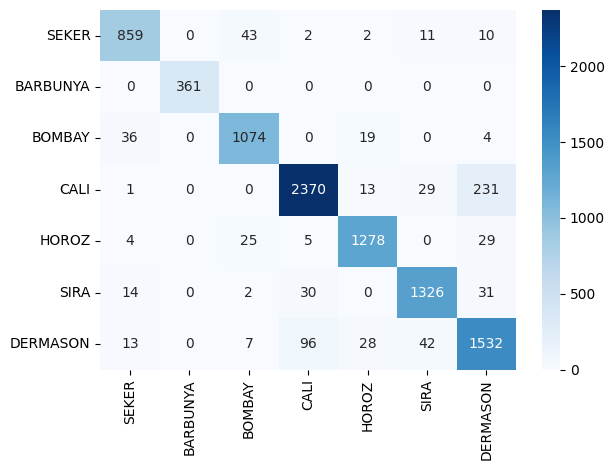

Test Set with Best Params Confusion matrix


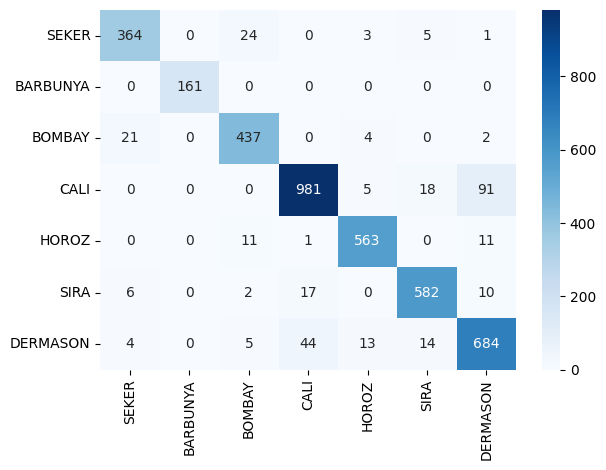

In [20]:
best_fit_test(neural_network_classifier_best, 1, "multi-layer neural network")


From the comparison between the confusion matrix with the best parameters and the default confusion matrix, not much improvement can be found. This is likely due to the fact that the default neural network classifier already has a high accuracy score and the dataset I have chosen is a bit noisy,

#### Neural Network Learning Curve


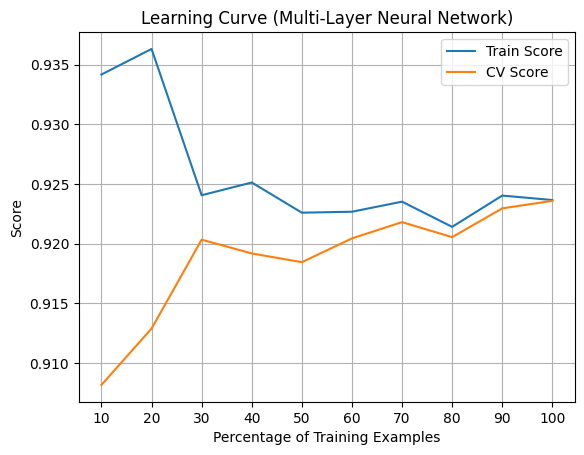

In [21]:
neural_network_classifier_learning = MLPClassifier(
    hidden_layer_sizes=(4, 4), random_state=42, max_iter=2000,
    learning_rate_init=neural_network_classifier_best.best_params_['learning_rate_init'],
    alpha=neural_network_classifier_best.best_params_['alpha'])
plot_learning_curve(neural_network_classifier_learning,
                    "Multi-Layer Neural Network")


From the learning curve of the nerual network, it shows a low bias in the training set since the convergence in training and CV scores occurs at a low percentage of training examples (around 30%).

### Training Loss and Score


Using the same hyper parameter, the loss curve which shows how error is reduced as the epochs keeps increasing during training is also plotted for the training set and the test set.

In [22]:
neural_network_classifier = MLPClassifier(
    hidden_layer_sizes=(4, 4), random_state=42, max_iter=1,
    alpha=neural_network_classifier_best.best_params_['alpha'],
    learning_rate_init=neural_network_classifier_best.best_params_['learning_rate_init'],
    warm_start=True
)
epochs = 300
training_loss = np.zeros(epochs)
training_score = np.zeros(epochs)
validation_score = np.zeros(epochs)

features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
for epoch in range(epochs):
    neural_network_classifier.fit(features_train_train, target_train_train)

    training_score[epoch] = accuracy_score(
        target_train_train, neural_network_classifier.predict(features_train_train))
    validation_score[epoch] = accuracy_score(
        target_train_test, neural_network_classifier.predict(features_train_test))

    training_loss[epoch] = neural_network_classifier.loss_

test_score = accuracy_score(
    TARGET_TEST, neural_network_classifier.predict(FEATURES_TEST))
print("Test set accuracy:", test_score)


Test set accuracy: 0.9272771792360431


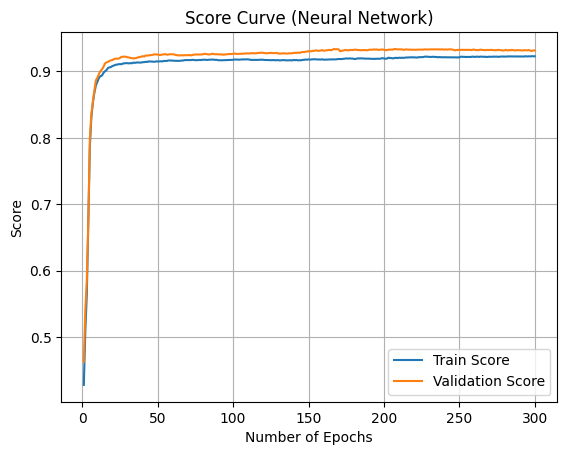

In [23]:
plt.figure()
plt.plot(np.arange(epochs) + 1, training_score, label='Train Score')
plt.plot(np.arange(epochs) + 1, validation_score, label='Validation Score')
plt.legend()
plt.title("Score Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.grid()
plt.savefig('images/dry_bean/dry_bean_neural_network_score_curve.png')
plt.show()


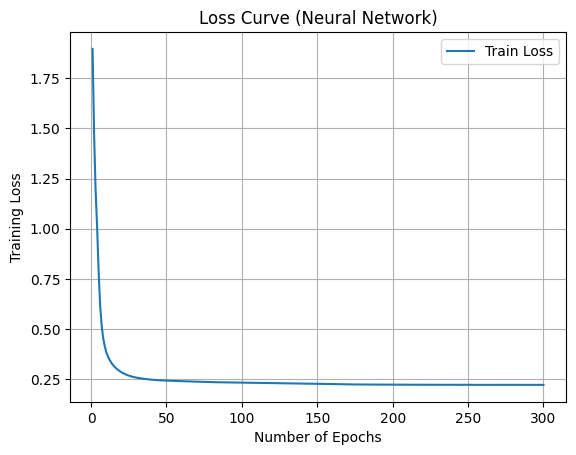

In [24]:
plt.figure()
plt.plot(np.arange(epochs) + 1, training_loss, label='Train Loss')
plt.legend()
plt.title("Loss Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.grid()
plt.savefig('images/dry_bean/dry_bean_neural_network_loss_curve.png')
plt.show()


The training loss keeps decreasing with increasing number of epochs as expected from the network.The smooth curve and the rate of decrement shows that the neural network is a good fit. The high training and validation scores also supports this conclusion.

### Single-Layer Neural Network


#### Pretuning


Train score 0.9393303243413457
Test score 0.933643486777669
Train Confusion matrix


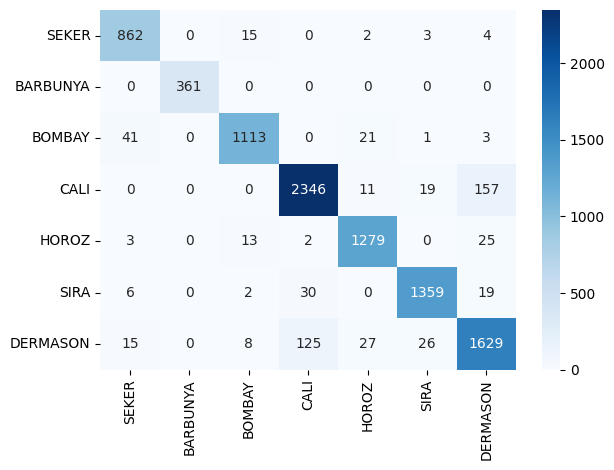

Test Confusion matrix


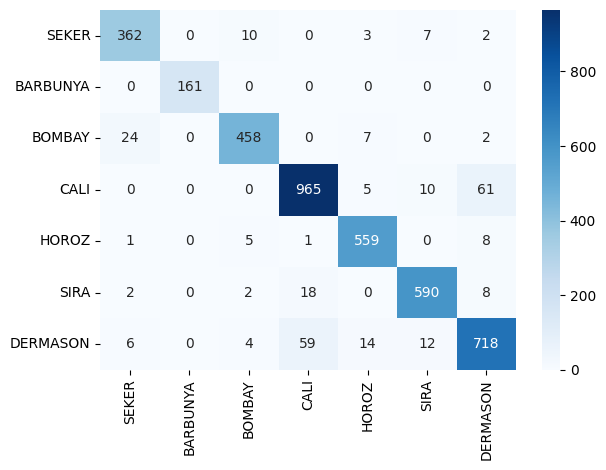

In [25]:
neural_network_classifier = MLPClassifier(random_state=42, max_iter=2000)
default_fit_test(neural_network_classifier)


Here I established a base case for a single-layer neural network. In this case the neural network works like a pipeline.

#### Tuning Regularization $\alpha$ and Hidden Layer Sizes


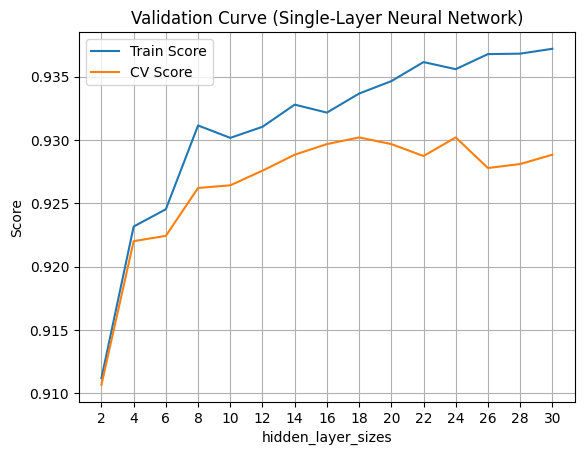

In [26]:
plot_validation_curve(
    neural_network_classifier, 'hidden_layer_sizes',
    np.arange(2, 31, 2), "Single-Layer Neural Network")


In [27]:
param_grid = {
    'alpha': np.logspace(-20, 1, 15),
    'hidden_layer_sizes': np.arange(2, 31, 2)
}
neural_network_classifier_best = grid_search_and_best_fit(
    neural_network_classifier, param_grid, 2, "single layer neural network")


Best params for single layer neural network: {'alpha': 0.01, 'hidden_layer_sizes': 24}


Instead of tuning the `learning_rate_init`, we will be tuning the `hidden_layer_sizes` for the single-layer neural network. Essentially, it determines how many different stages a perceptron vector needs to go through from input ot output. From the grid search, we know that the best `hidden_layer_sizes` is 24 and the best $\alpha$ in this case is 0.00306.

Accuracy for best single layer neural network on train sets: 0.9357615198908366
Accuracy for best single layer neural network on test sets: 0.933643486777669
Train Set with Best Params Confusion matrix


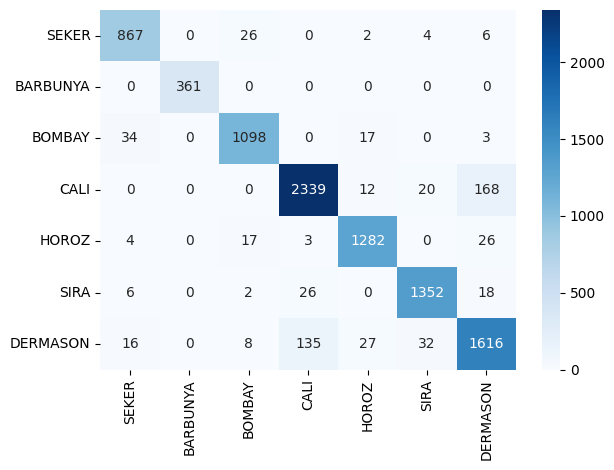

Test Set with Best Params Confusion matrix


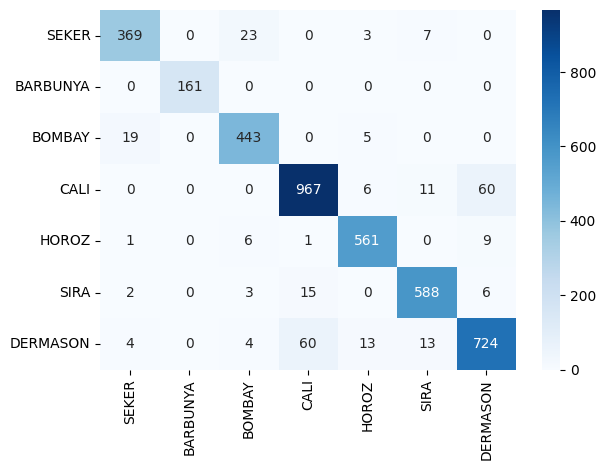

In [28]:
best_fit_test(neural_network_classifier_best, 2, "single layer neural network")


Surprisingly, the single-layer neural network actually does better than the multi-layer nerual network. Normally, a multi-layer neural network can introduce more non-linearity than a single-layer neural network can and thus should perform better. One possible reason is that the dataset is extremely biased towwards linear relationship.

#### Nerual Network Learning Curve


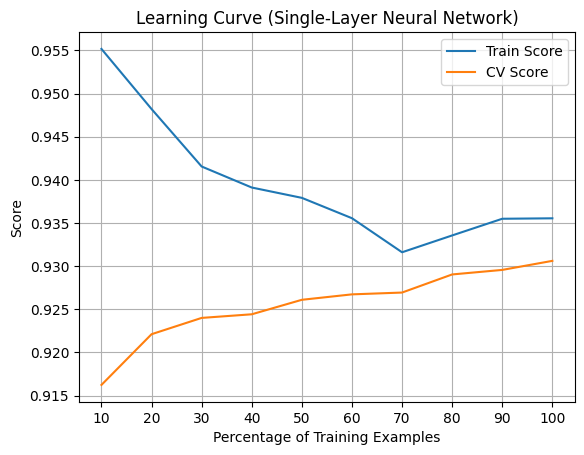

In [29]:
neural_network_classifier_learning = MLPClassifier(
    random_state=42, max_iter=2000,
    hidden_layer_sizes=neural_network_classifier_best.best_params_['hidden_layer_sizes'],
    alpha=neural_network_classifier_best.best_params_['alpha'])
plot_learning_curve(neural_network_classifier_learning,
                    "Single-Layer Neural Network")


The learning curve of the single-layer neural network does not show as a strong trend of convergence as the multi-layer neural network does. This might be caused by the fact that a single layer can not capture the non-linearity a multi-layer can produce as the perceptrons feed forward.

## Boosting


### Pretuning


Train score 0.6488926209719744
Test score 0.6466699314397649
Train Confusion matrix


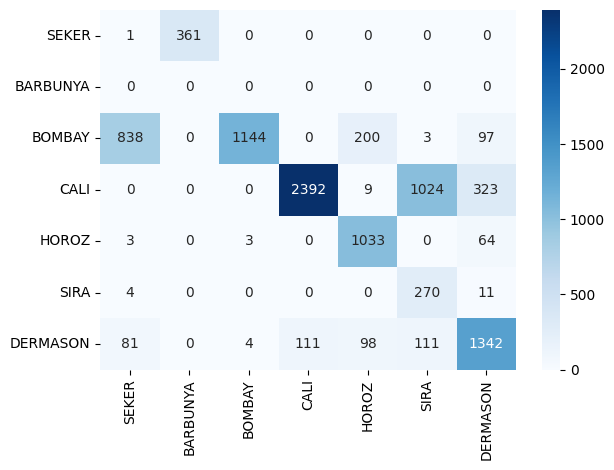

Test Confusion matrix


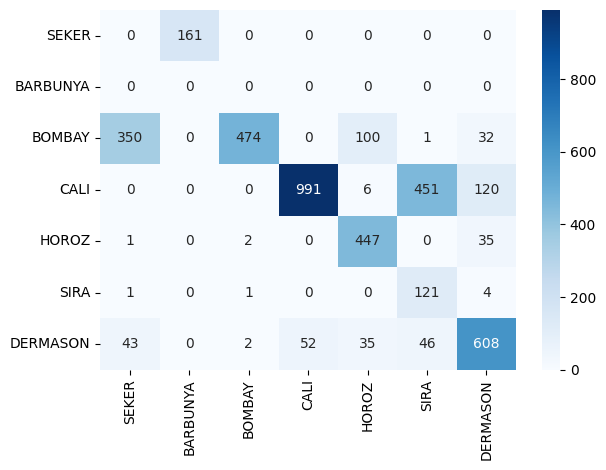

In [30]:
adaboost_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
    max_depth=1, min_samples_leaf=1), random_state=42)
default_fit_test(adaboost_classifier)


Before any study is done, a base case for the Boosting Classifier should be established. The boosting classifier here is using a single leaf decision tree as a weak learner.

### Tuning N-Estimators and Learning Rate


The parameters that will be tuned here are `n_estimators` which represent the amount of weak leraners and `learning_rate`. The `n_estimators` ranges from [1, 300) and the `learning_rate` ranges from $[10^{-5}, 10)$

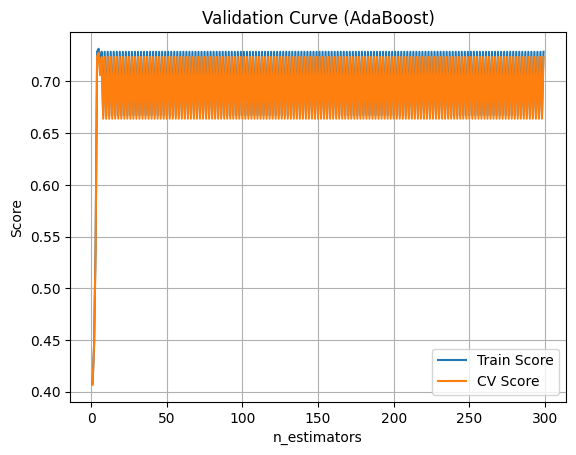

In [31]:
plot_validation_curve(
    adaboost_classifier, 'n_estimators',
    np.arange(1, 300), "AdaBoost",
    default_xticks=True)


The figure above is quite interesting is the both the CV scroe and the train score oscillates after the number of weak learners passes a certain value. It almost feels like the weak learner learned one "hard" instance but got it wrong again on the previous "hard" instance. This really shows that the dataset has some contradictory instances and is very noisy.

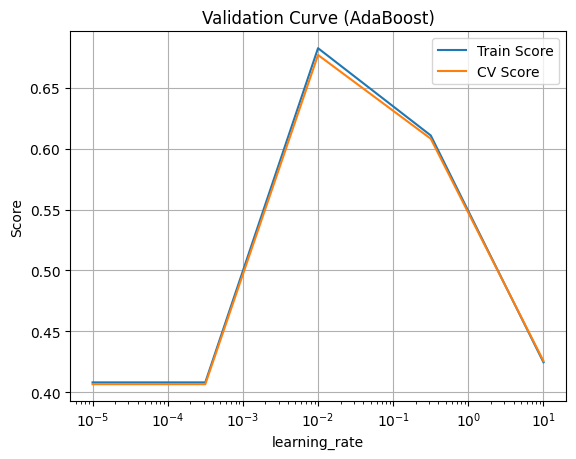

In [32]:
plot_validation_curve(
    adaboost_classifier, 'learning_rate',
    np.logspace(-5, 1, 5), "AdaBoost",
    default_xticks=True, xaxis_log=True)


In [33]:
param_grid = {
    'learning_rate': np.logspace(-5, 1, 5),
    'n_estimators': np.arange(1, 300)
}
adaboost_classifier_best = grid_search_and_best_fit(
    adaboost_classifier, param_grid, 3, "adaboost")


Best params for adaboost: {'learning_rate': 0.31622776601683794, 'n_estimators': 188}


From the grid search, the best parameter for `learning_rate` and `n_estimators` are 0.31 and 188 respectively.

Accuracy for best adaboost on train sets: 0.5516951821139918
Accuracy for best adaboost on test sets: 0.5634182174338883
Train Set with Best Params Confusion matrix


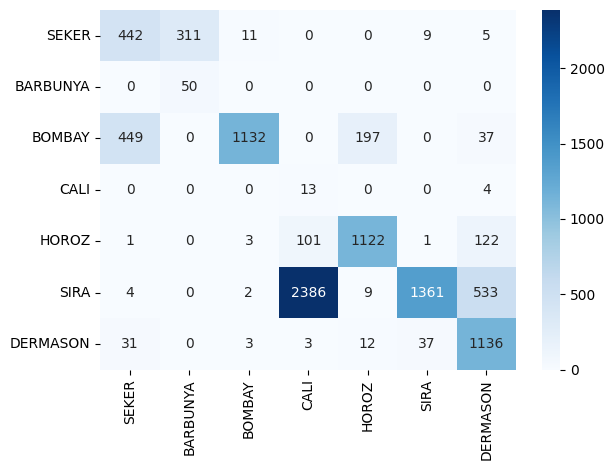

Test Set with Best Params Confusion matrix


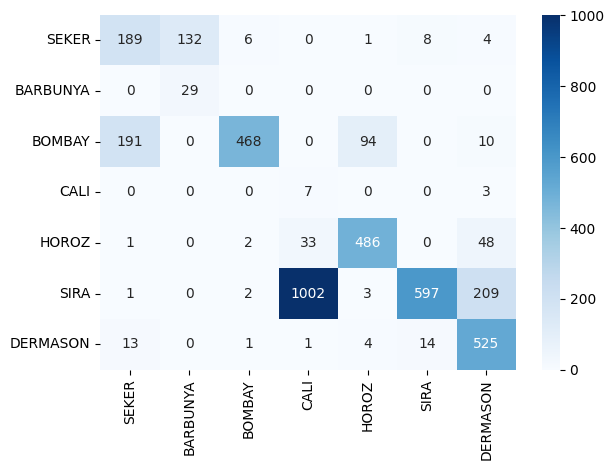

In [34]:
best_fit_test(adaboost_classifier_best, 3, "adaboost")


### Adaboost Learning Curve


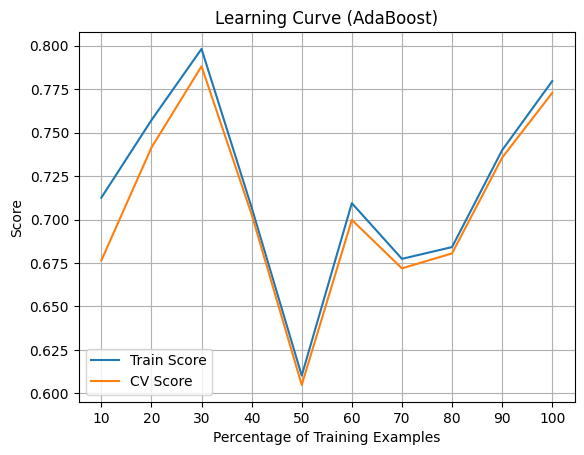

In [35]:
adaboost_classifier_learning_curve = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
    max_depth=1, min_samples_leaf=1), random_state=42,
    n_estimators=adaboost_classifier_best.best_params_['n_estimators'],
    learning_rate=adaboost_classifier_best.best_params_['learning_rate'])
plot_learning_curve(adaboost_classifier_learning_curve, "AdaBoost")


The learning curve for the Adaboost is quite intersting as both training score and CV score reach a high point when the percentage is 30% and the two curves never seems to be parting away. The explanantaion for the convergeance can be explained by the fact that the AdaBoost classifier suffers from high bias, which means introducing more complexity in the model would be beneficial to increasing its performance. Together with the results from other classifier and the relatively low accuracy score from the boosting rate, I think the spike at the 30% point could be a result of noisy datapoint.

## SVM


### Pretuning


Train score 0.9279941219691403
Test score 0.9260528893241919
Train Confusion matrix


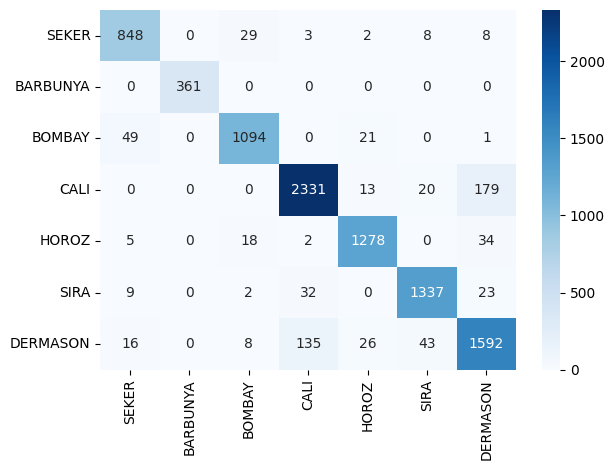

Test Confusion matrix


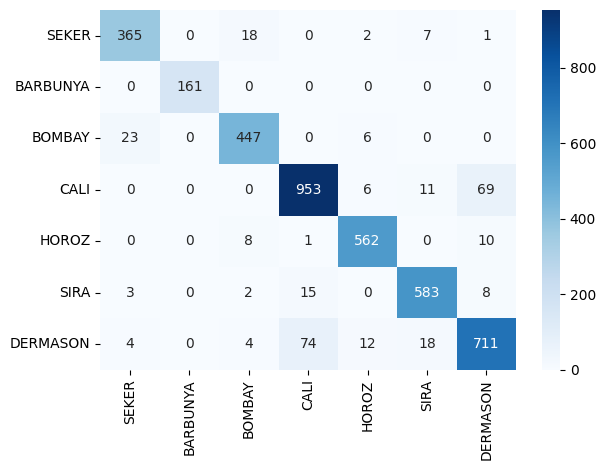

In [36]:
svm_classifier = SVC(kernel='linear', random_state=42)
default_fit_test(svm_classifier)


Before any study is done, a base case for the SVM Classifier should be established, that is a SVM Classifier without any hyperparameter tuning.

### Tuning Regularization C and Kernel Method


The parameters that are tuned are `C` which is the regularization parameter and the kernel method. The regularization parameter ranges from $[1, 10^{1.5})$ and the kernel method will be one of the four methods: linear, rbf, poly and sigmoid.

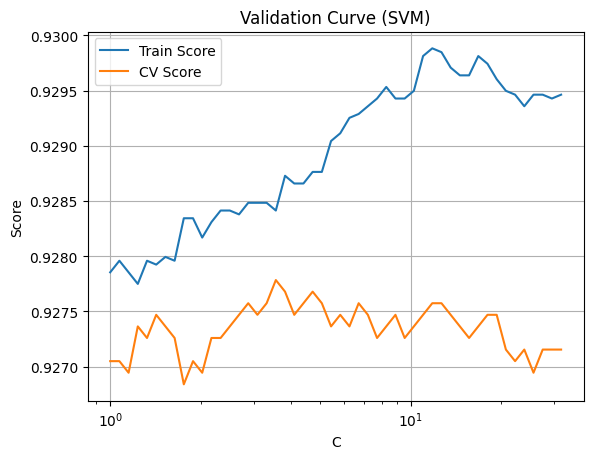

In [37]:
plot_validation_curve(
    svm_classifier, 'C',
    np.logspace(0, 1.5), "SVM",
    default_xticks=True, xaxis_log=True)


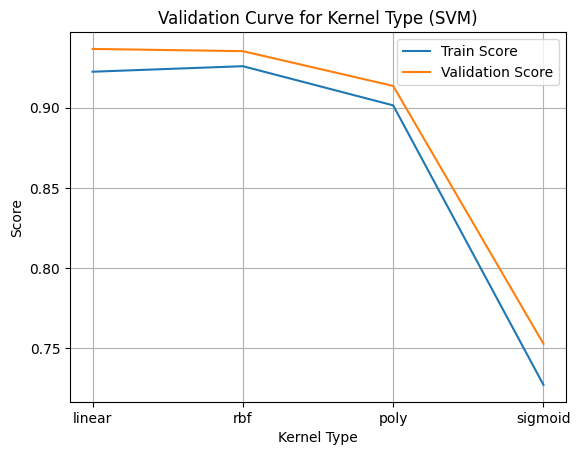

In [38]:
train_scores = np.zeros((4, 1))
test_scores = np.zeros((4, 1))

svm_classifier = svm.SVC(random_state=42, kernel='linear')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[0] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[0] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='rbf')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[1] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[1] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='poly')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[2] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[2] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='sigmoid')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[3] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[3] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

plt.figure()
plt.plot(np.arange(0, 4), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(0, 4), np.mean(
    test_scores, axis=1), label='Validation Score')
plt.legend()
plt.title("Validation Curve for Kernel Type (SVM)")
plt.xlabel("Kernel Type")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(4), ['linear', 'rbf', 'poly', 'sigmoid'])
plt.savefig('images/dry_bean/dry_bean_svm_kernel_validation_curve.png')
plt.show()


In [39]:
param_grid = {
    'C': np.logspace(0, 1.5),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
svm_classifier_best = grid_search_and_best_fit(
    svm_classifier, param_grid, 4, "SVM")


Best params for SVM: {'C': 20.716983998953076, 'kernel': 'rbf'}


As seen from the validation curve, the train score keeps increasing, but the CV score drops beyond a certain value of the regularization parameter `C`. Therefore, we do grid search on the hyper-parameter `C` and the kernel method. The best parameters are 20.716 for `C` with the RBF kernel.

Accuracy for best SVM on train sets: 0.9400650781988034
Accuracy for best SVM on test sets: 0.932664054848188
Train Set with Best Params Confusion matrix


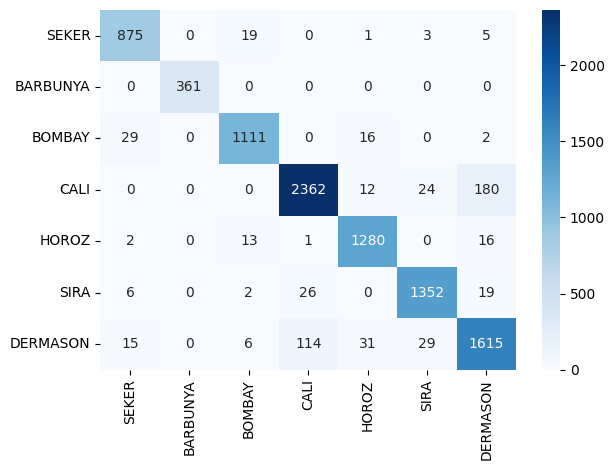

Test Set with Best Params Confusion matrix


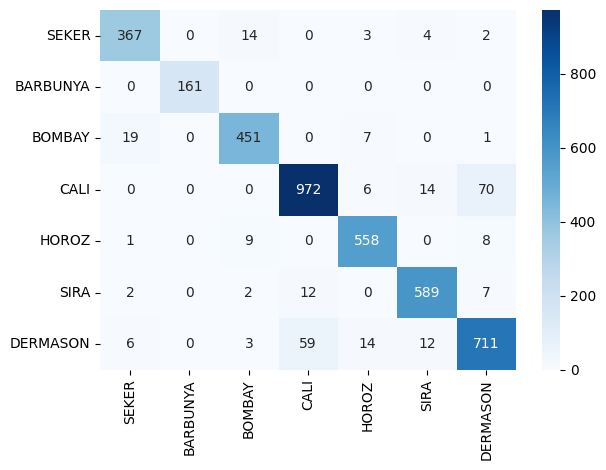

In [40]:
best_fit_test(svm_classifier_best, 4, "SVM")


With the best parameters, the SVM classifier improves on both the training score and the testing score which is the only one out of the five different classifiers.

### SVM Learning Curve


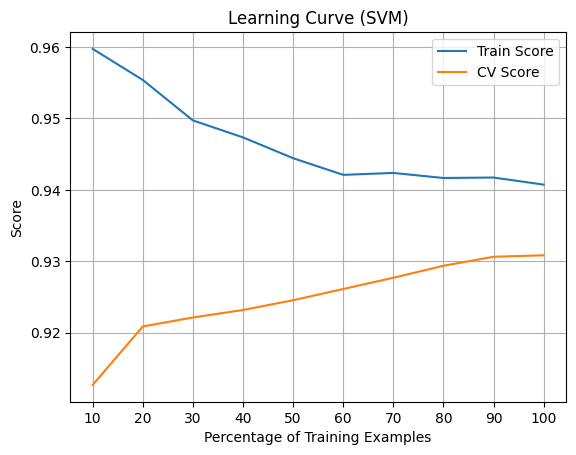

In [41]:
svm_classifier_learning = svm.SVC(
    random_state=42, C=svm_classifier_best.best_params_['C'],
    kernel=svm_classifier_best.best_params_['kernel'])
plot_learning_curve(svm_classifier_learning, "SVM")


Finally we look at the learning curve and see that the train score and CV score have the trend of convergence but there is still a substantial gap when it reaches the maximum percentage of training examples. This is can be the result of noise in the data set. The convergence trend also points to the fact that the SVM classifier is biased, and a more complex model could help increase its performance.

## k-Nearest Neighbors


### Pretuning


Train score 0.9415345859137189
Test score 0.9214005876591577
Train Confusion matrix


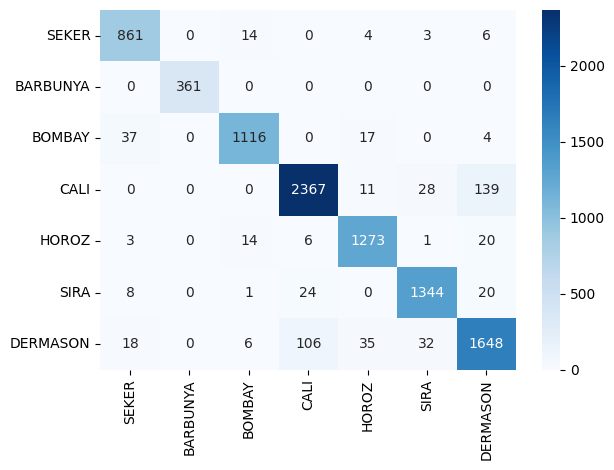

Test Confusion matrix


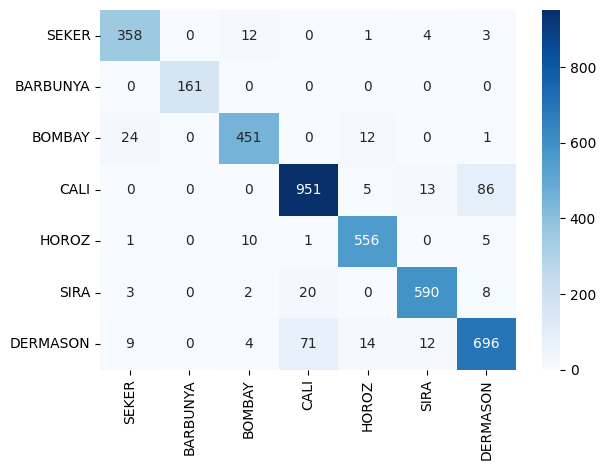

In [42]:
knn_classifier = KNeighborsClassifier()
default_fit_test(knn_classifier)


Before any study is done, a base case for the k-Nearest Neighbour Classifier should be established, that is a k-NN Classifier without tuning the number of neighbours and the power parameter of the Minkowski distance function. From what the confusion matrix is showing, the training score and the CV score is already pretty close to each other with the default case (n_neighbors=5, p=2).


### Tune Number of Neighbors & Minkowski Power Parameter


The hyper parameter I have chosen for the k-NN classifier are `n_neighbors` which stands for number of neighbours and `p` which is the power parameter for the Minkowski distance function. The range for `n_neighbors` is [1, 201) and the range for `p` is [1, 10).

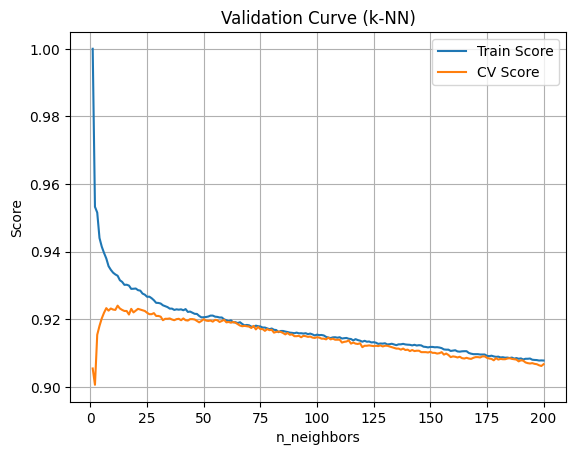

In [43]:
plot_validation_curve(
    knn_classifier, 'n_neighbors',
    np.arange(1, 201), "k-NN",
    default_xticks=True)


The above image shows the relationship of the training score and the CV score with the number of neighbours. The CV score reaches its maximum when the number of neighbours at a certain value and then starts to decrease together with the training score. The reason is likely to be the bias in the model which keeps increasing as the number of neighbours increases. Essentially, when the k is too small, it's more likely to overfit since the classifier is very sensitive to anomalies whereas when the k is too big, the classifier is going to underfit since it' slowly ignoring the local particularities.


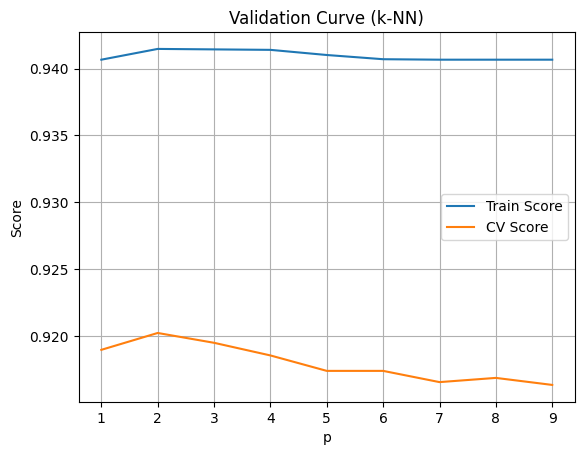

In [44]:
plot_validation_curve(knn_classifier, 'p', np.arange(1, 10), "k-NN")


The above image shows the relationship of the training score and the CV score when tuning the power parameter for the Minkowski distance function. The CV score reaches its maximum when the power parameter is 2 and then starts to decrease. 

In [45]:
param_grid = {
    'n_neighbors': np.arange(1, 201),
    'p': np.arange(1, 10)
}
knn_classifier_best = grid_search_and_best_fit(
    knn_classifier, param_grid, 5, "k-NN")


Best params for k-NN: {'n_neighbors': 12, 'p': 2}


After the grid search, the best parameter combination for number of neighbours and power parameter for the Minkowski distance function is 12 and 2 respectively.


Accuracy for best k-NN on train sets: 0.9319827857667682
Accuracy for best k-NN on test sets: 0.9253183153770813
Train Set with Best Params Confusion matrix


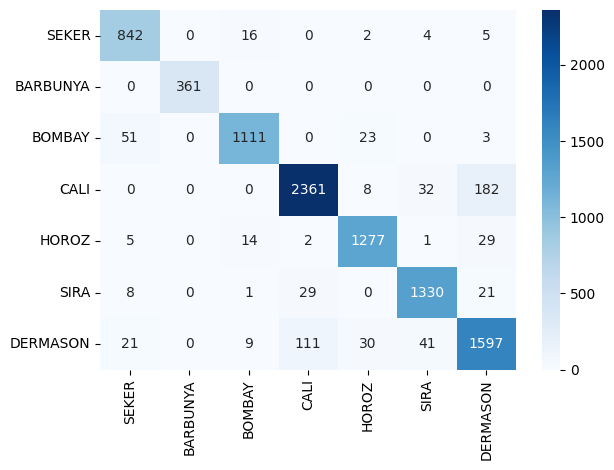

Test Set with Best Params Confusion matrix


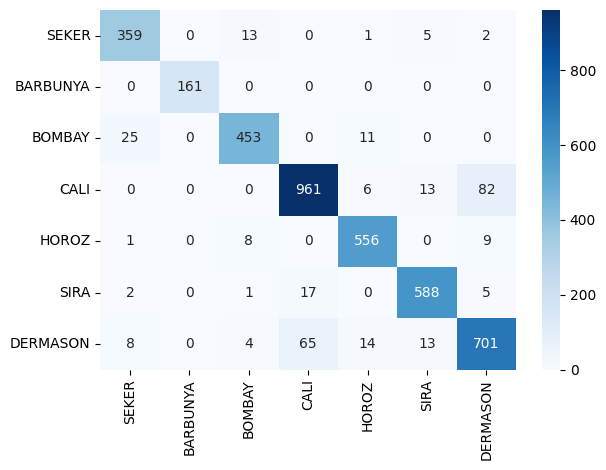

In [46]:
best_fit_test(knn_classifier_best, 5, "k-NN")


The confusion matrix on training set and testing set are plotted again for comparison. We can see that the accuracy score for the training set stays roughly the same but the accuracy score for the testing set is improving. The majority of the improvement and the mjority of the error comes from CALI being categorized as DERMASON and DERMASON being ategorized as CALI. One possible explnation for this phenomenon is that DERMASON and CALI are extremely similar beans and since it's a image processing dataset, we may need more data to better differentiate them.


### k-Nearest Neighbors Learning Curve

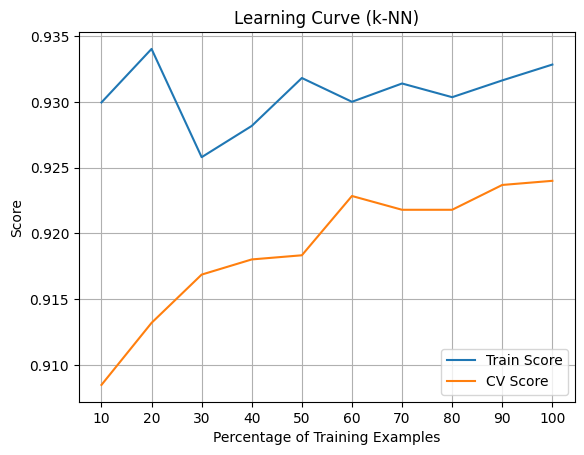

In [47]:
knn_classifier_learning = KNeighborsClassifier(
    n_neighbors=knn_classifier_best.best_params_['n_neighbors'],
    p=knn_classifier_best.best_params_['p'])
plot_learning_curve(knn_classifier_learning, "k-NN")


From the above image, we can see that with the percentage of training example increasing, the train score stays roughly the same (around 93%), but the CV score is improving steadily (from 90.8% to 92.4%) which suggests that the data I have chosen may be intrinsically biased towards complicated model.

## Time Comparison

In [54]:
classifiers: list[str] = ["DT", "ML NN", "SL NN", "Boosting", "SVM", "k-NN"]
y_ticks = np.arange(len(classifiers))
print(f"Training Time: {train_time}")
print(f"Inference Time: {infer_time}")
print(f"Accuracy: {classifier_accuracy}")

Training Time: [  143.86736059  3992.50806689  3812.4761591  13228.73259115
   427.73830438 12744.59304881]
Inference Time: [0.00156736 0.00549531 0.00597787 0.14238906 0.38025951 0.16906595]
Accuracy: [0.90058766 0.92360431 0.93364349 0.56341822 0.93266405 0.92531832]


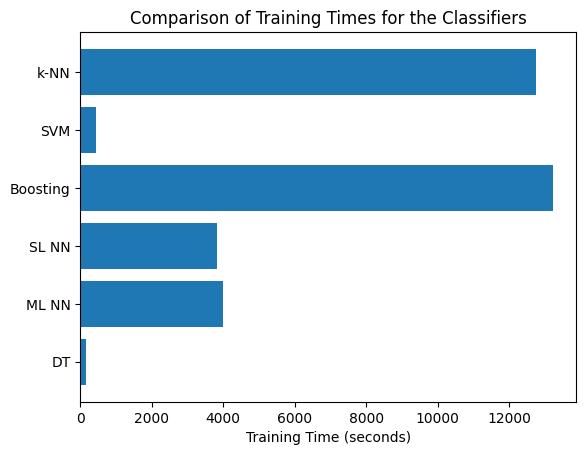

In [55]:
plt.figure()
plt.barh(y_ticks, train_time)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Training Times for the Classifiers')
plt.xlabel('Training Time (seconds)')
plt.savefig('images/dry_bean/dry_bean_training_time.png', dpi=300, bbox_inches='tight')
plt.show()

For the Dry Bean dataset, Boosting and k-NN classifiers took the longest time. This is likely due to a large number neighbours for the knn classifier and a large number of weak learners for the boosting classifier. Decision tree is trained the fastest as expected as the max depth of the tree is controlled using the max depth hyper-parameter. The neural network training times are also relatively high because the neural network needs to adjust the weight for each perceptron through backpropagation for gradient computation and the more layers/nodes there are in the NN, the longer it takes.

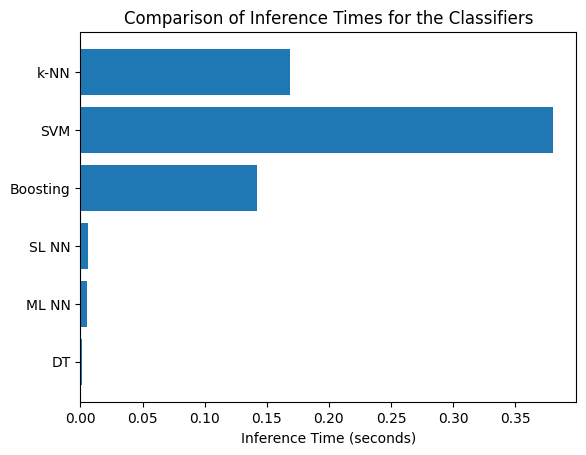

In [50]:
plt.figure()
plt.barh(y_ticks, infer_time)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Inference Times for the Classifiers')
plt.xlabel('Inference Time (seconds)')
plt.savefig('images/dry_bean/dry_bean_infer_time.png', dpi=300, bbox_inches='tight')
plt.show()

Inference time for decision trees is also low as expected since tree traversal is trivial. For the k-NN classifier, since the distance to each neighbor has to be computed, it will take some time when the number of neighbours taken into account is high. For Adaboost, as the inference is completed for each weak learner, it will take some time with a large number of weak leraners. Both NN classifiers are relatively faster since the NN classifiers only need a single forward pass for each test case. What really surprises me is that the SVM takes the longest time to predict the testing set. A likely explanantion is that given how noisy this dataset is, the function that produces the maximum margin at the boundary layer might be very complicated and thus taking a lot of computing time.

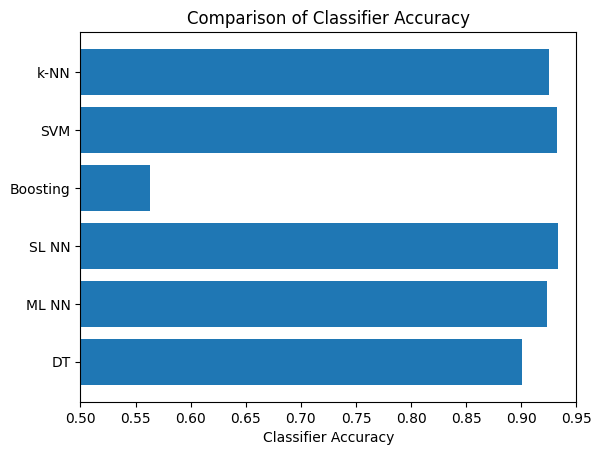

In [52]:
plt.figure()
plt.barh(y_ticks, classifier_accuracy)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Classifier Accuracy')
plt.xlabel('Classifier Accuracy')
plt.gca().set_xlim(0.5, 0.95)
plt.savefig('images/dry_bean/dry_bean_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

For the dry bean dataset, all classifier performs relatively similar except the Adaboost classifier. As I mentioned in the analysis of the validation curve for `n_estimators`, the quirtky oscillating behvaiour indicates that when the weak learner is getting something right, as the same time the prediction on some other cases might be wrong. Without considering the Boosting Classifier, the average accruacy score of the other 5 classifiers is only 92.3% which is a relatively low compared to a classifier that is a good fit to the dataset. This observation also shows that the dataset is noisy.